In [1]:
import argparse
import os

In [2]:
a = [i for i in range(29)]

In [9]:
a[:11], a[11: 22], a[22:25], a[25:-1], a[-1]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 [22, 23, 24],
 [25, 26, 27],
 28)

In [2]:
def get_args_parser():
    parser = argparse.ArgumentParser(
        'EfficientFormer training and evaluation script', add_help=False)
    parser.add_argument('--batch-size', default=8, type=int)
    parser.add_argument('--epochs', default=50, type=int)

    # Model parameters
    parser.add_argument('--model', default='S_EleViTDecoder', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--input-size', default=[256, 512],
                        type=int, help='images input size')


    # Optimizer parameters
    parser.add_argument('--opt', default='AdamW', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    
    # Learning rate schedule parameters
    parser.add_argument('--sched', default='CosineAnnealingLR', type=str, metavar='SCHEDULER',
                        help='LR scheduler (default: "cosine"')
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')


    # Loss parameters
    parser.add_argument('--loss', default='DepthL1Loss', choices=['DepthL1Loss',  'FullLoss'],
                        type=str, help='Image Net dataset path')
    # semantic Loss parameters
    parser.add_argument('--se_loss', default='CrossEntropyLoss', choices=['CrossEntropyLoss',  'FullLoss'],
                        type=str, help='Image Net dataset path')
    # Dataset parameters
    parser.add_argument('--validation_split', default=0.15,
                        type=float, help='images input size')
    parser.add_argument('--metric_scale', default=512.0,
                        type=float, help='images input size')
    parser.add_argument('--dataset', default='s3d', choices=['s3d', 'ade20k'],
                        type=str, help='Image Net dataset path')
    parser.add_argument('--folders', default=['Data/full'], type = int, 
                        nargs="*",help='Image Net dataset path')
    
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--output_dir', default='check_points',
                        help='path where to save, empty for no saving')
    parser.add_argument('--eval', default='',
                        help='path from where to load')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=2023, type=int)
    parser.add_argument('--dist-eval', action='store_true',
                        default=False, help='Enabling distributed evaluation')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--option', default='all', type=str, choices=['all',  'semantic', 'depth', 'alb_shading'])
    parser.add_argument('--outsize', default=1, type=int)
    parser.add_argument('--pin-mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no-pin-mem', action='store_false', dest='pin_mem',
                        help='')
    parser.set_defaults(pin_mem=True)
    
    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')
    
    return parser
parser = argparse.ArgumentParser(parents=[get_args_parser()])

In [3]:
args = get_args_parser()
args.input_size = [256, 512]
args.outsize = 1
args.dataset = 's3d'
args.folders = ["../Data/full"]
args.validation_split = 0.1
args.option = "all"

In [4]:
from datasets import build_dataset
import numpy as np
train_dataset, test_dataset = build_dataset(args)

In [5]:
from torch.utils.data import DataLoader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4)

In [10]:
data = next(iter(train_loader))

../Data/full/normal/scene_00010_846210.png ../Data/full/depth/scene_00010_846210.png
../Data/full/normal/scene_00217_163528.png ../Data/full/depth/scene_00217_163528.png
../Data/full/normal/scene_01313_833737.png ../Data/full/depth/scene_01313_833737.png
../Data/full/normal/scene_03058_11551.png ../Data/full/depth/scene_03058_11551.png


In [11]:
from normal_reconstruct import reconstruct

In [12]:
out = reconstruct(data['depth'])

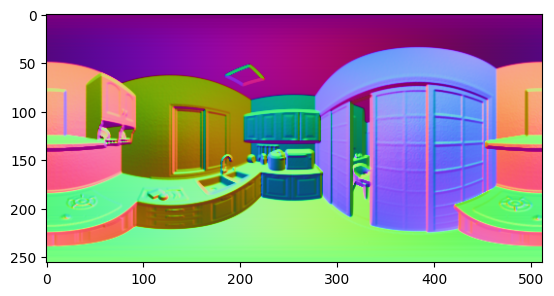

In [13]:
import matplotlib.pyplot as plt

plt.imshow(0.5*out[2].permute(1,2, 0)+0.5)

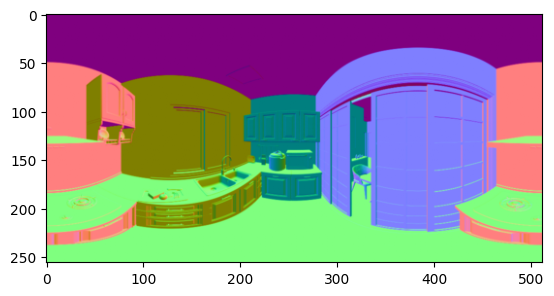

In [14]:
plt.imshow(0.5*(2.0*data['normal'][2].permute(1,2, 0)-1)+0.5)

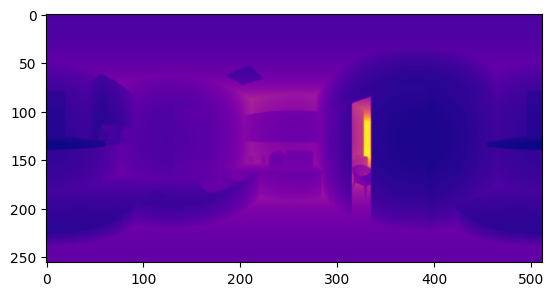

In [15]:
plt.imshow(data['depth'][2].permute(1,2, 0), cmap = 'plasma')

In [17]:
import torch
import torch.nn.functional as F
import numpy as np

# Function to calculate the angular error between two vectors
def angular_error(n_gt, n_hat):
    # Convert to PyTorch tensor if input is a NumPy array
    if isinstance(n_gt, np.ndarray):
        n_gt = torch.from_numpy(n_gt)
    if isinstance(n_hat, np.ndarray):
        n_hat = torch.from_numpy(n_hat)

    n_gt = 2.0*n_gt-1
    # Normalizing the vectors to avoid division by zero errors in case of non-normalized inputs
    n_gt_norm = F.normalize(n_gt, p=2, dim=2)
    n_hat_norm = F.normalize(n_hat, p=2, dim=2)

    # Calculate the cosine of the angular error
    w = torch.sum(n_hat_norm * n_hat_norm, dim=2) > 0
    cos_angle_error = torch.clamp(torch.sum(n_gt_norm * n_hat_norm, dim=2), -1.0, 1.0)

    # Calculate the angle in radians and then convert to degrees
    angle_error_rad = torch.acos(cos_angle_error) * w
    angle_error_deg = torch.rad2deg(angle_error_rad)

    return angle_error_deg

# Function to calculate the Average Angular Error (AAE)
def average_angular_error(n_gt, n_hat):
    angle_error_deg = angular_error(n_gt, n_hat)
    aae = torch.mean(angle_error_deg.float())
    return aae

# Function to calculate the Proportion of Good Pixels (PGP)
def proportion_good_pixels(n_gt, n_hat, phi):
    angle_error_deg = angular_error(n_gt, n_hat)
    pgp = torch.mean((angle_error_deg <= phi).float())
    return pgp

# Angular error tolerance (in degrees)
phi = 20.0


n_gt, n_hat = data['normal'], out
angle_error_deg = angular_error(n_gt, n_hat)
# Compute the Average Angular Error (AAE)
aae = average_angular_error(n_gt, n_hat)

# Compute the Proportion of Good Pixels (PGP)
pgp = proportion_good_pixels(n_gt, n_hat, phi)

print(f'Average angular error = {aae.item()}')
print(f'Proportion of good pixels < {phi} degrees = {pgp.item()}')

Average angular error = 38.247440338134766
Proportion of good pixels < 20.0 degrees = 0.41015625
